
# TÂCHE 1 : COLLECTE ET PRÉPARATION DES DONNÉES
## Objectif : 
Identifier et collecter des données démographiques, économiques et sociales sur le Bénin à partir de sources fiables (World Bank, WHO, ONU, etc.) Nettoyer, harmoniser et consolider ces données dans un format unique, prêt pour l’analyse.


In [1]:
#1
# Définition du répertoire de base du projet.
# Cette cellule garantit que le notebook fonctionne quel que soit
# l’emplacement depuis lequel il est exécuté (notebooks/ ou racine).

import sys, pathlib
BASE = pathlib.Path.cwd().resolve().parents[0] if (pathlib.Path.cwd().name == "notebooks") else pathlib.Path.cwd()
if str(BASE) not in sys.path:
    sys.path.insert(0, str(BASE))
print("BASE:", BASE)

BASE: /Users/davidakpovi/challenge_tache1_ANIP


In [2]:
#2
# Import des bibliothèques nécessaires :
#  - pandas pour la manipulation de données
#  - yaml/json pour les fichiers de configuration
#  - fonctions personnalisées créées dans le dossier src/

import json, yaml
import pandas as pd
from src.collect import run_collect, RAW_DIR
from src.clean import standardize_columns, coerce_numeric, coerce_string, fillna_with, convert_units, save_interim
from src.harmonize import harmonize_geo, harmonize_year, consolidate, export_final

In [4]:
#3
# Diagnostic d'import du module `src.collect`
# But :
#   - Vérifier que le module importé est bien celui du projet (chemin réel du fichier).
#   - Afficher un extrait du code source de `run_collect()` sans l’exécuter.
# Intérêt :
#   - Détecter d’éventuels conflits de versions/dossiers (ancien `collect.py` ailleurs).
#   - Comprendre rapidement ce que fait `run_collect()` quand un comportement surprend.
# Remarques :
#   - Cette cellule n’effectue aucune collecte de données.
#   - En cas de modification récente de `src/collect.py`, on peut forcer le rechargement :
#       # import importlib; importlib.reload(c)

import inspect, importlib, sys
import src.collect as c
print("collect.py chargé depuis :", c.__file__)
print("\nAperçu de run_collect :\n", inspect.getsource(c.run_collect)[:400])


collect.py chargé depuis : /Users/davidakpovi/challenge_tache1_ANIP/src/collect.py

Aperçu de run_collect :
 def run_collect(config_path: str = str(BASE_DIR / "config" / "sources.yml")) -> List[pathlib.Path]:
    import yaml
    collected = []
    cfg = load_sources(pathlib.Path(config_path))
    for src in cfg.get("sources", []):
        sid = src["id"]
        stype = src.get("type")
        url = src.get("url")
        params = src.get("params", {})
        fmt = src.get("format", "csv")
        if st


In [5]:
#4
# Nettoyage du fichier de configuration des sources
# Objectif :
#   - Charger le fichier YAML "sources.yml" qui répertorie les jeux de données à collecter.
#   - Supprimer les entrées liées au FMI (IMF) qui provoquent des erreurs d’accès API.
#   - Réécrire le fichier YAML mis à jour sans ces sources problématiques.

# Étapes :
#   1. Charger le fichier de configuration via yaml.safe_load().
#   2. Compter le nombre total de sources initiales.
#   3. Filtrer la liste pour retirer toute source dont l'identifiant contient "imf".
#   4. Réécrire le fichier nettoyé et afficher le nombre de sources avant/après.
#
# Remarque :
#   - Cette cellule ne modifie pas les données collectées, uniquement la configuration.
#   - Elle évite que la fonction run_collect() échoue sur les API IMF non accessibles.

import yaml, pathlib

cfg_path = BASE / "config" / "sources.yml"
with open(cfg_path, "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

before = len(cfg.get("sources", []))
# Supprime toute source dont l'id contient "imf"
cfg["sources"] = [s for s in cfg.get("sources", []) if "imf" not in s.get("id","").lower()]
after = len(cfg["sources"])

with open(cfg_path, "w", encoding="utf-8") as f:
    yaml.safe_dump(cfg, f, sort_keys=False, allow_unicode=True)

print(f"Sources avant: {before} | après suppression IMF: {after}")


Sources avant: 5 | après suppression IMF: 5


In [7]:
#5
# Collecteur tolérant : saute l'IMF (au cas où), continue si une source échoue
#Collecte des données avec gestion des erreurs
# Objectif :
#   - Créer une version plus robuste de la fonction de collecte (run_collect_tolerant)
#     capable de poursuivre même si certaines sources échouent.
#   - Éviter les interruptions lors du téléchargement à cause d’erreurs réseau ou API.
#
# Détails :
#   - Lecture du fichier de configuration "sources.yml" pour récupérer la liste des sources.
#   - Boucle sur chaque source :
#       → Type "download" : télécharge un fichier CSV ou autre.
#       → Type "api" : récupère des données JSON depuis une API.
#       → Type "scrape" : placeholder pour un futur scraping.
#   - Ignore automatiquement les sources IMF (souvent inaccessibles).
#   - En cas d’erreur sur une source, logue le message et continue si continue_on_error=True.
#   Cette approche garantit que la collecte s’exécute entièrement,
#   même si certaines sources échouent temporairement.


from src.collect import RAW_DIR, download_file, get_api_json, save_json, safe_filename, log
import yaml, pathlib

def run_collect_tolerant(config_path: str, continue_on_error: bool = True):
    collected = []
    with open(config_path, "r", encoding="utf-8") as f:
        cfg = yaml.safe_load(f)
    for src in cfg.get("sources", []):
        sid   = src.get("id", "unknown")
        stype = src.get("type")
        url   = src.get("url")
        params= src.get("params", {})
        fmt   = src.get("format", "csv")

        # Sécurité: skip IMF au cas où
        if "imf" in sid.lower():
            log(f"[INFO] Skipping IMF source '{sid}'")
            continue

        try:
            if stype == "download":
                out = RAW_DIR / f"{safe_filename(sid)}.{fmt}"
                collected.append(download_file(url, out))
            elif stype == "api":
                data = get_api_json(url, params=params)
                out = RAW_DIR / f"{safe_filename(sid)}.json"
                save_json(data, out)
                collected.append(out)
            elif stype == "scrape":
                log(f"[WARN] Scraping non implémenté pour {sid}.")
            elif stype in (None, "disabled"):
                log(f"[INFO] Source '{sid}' ignorée (type={stype}).")
            else:
                log(f"[WARN] Type inconnu pour {sid}.")
        except Exception as e:
            log(f"[ERROR] Source '{sid}' échouée: {e}")
            if not continue_on_error:
                raise
    return collected


In [9]:
#6
# Lancement de la collecte des données
# Objectif :
#   - Exécuter la fonction de collecte principale (run_collect)
#     en utilisant le fichier de configuration "sources.yml".
#   - Télécharger ou récupérer les données depuis les sources définies.
# Détails :
#   - Chaque source listée dans le fichier YAML (cfg_path) est traitée :
#       → soit par téléchargement direct (URL),
#       → soit via une API,
#       → soit par scraping (si implémenté).
#   - Les fichiers collectés sont enregistrés dans le dossier "data/raw".
# Sortie :
#   - collected_paths : liste des chemins des fichiers collectés.

collected_paths = run_collect(str(cfg_path))
collected_paths

[PosixPath('/Users/davidakpovi/challenge_tache1_ANIP/data/raw/wb_population_total_benin.json'),
 PosixPath('/Users/davidakpovi/challenge_tache1_ANIP/data/raw/wb_gdp_current_usd_benin.json'),
 PosixPath('/Users/davidakpovi/challenge_tache1_ANIP/data/raw/wb_gdp_real_growth_benin.json'),
 PosixPath('/Users/davidakpovi/challenge_tache1_ANIP/data/raw/wb_life_expectancy_benin.json'),
 PosixPath('/Users/davidakpovi/challenge_tache1_ANIP/data/raw/wb_maternal_mortality_benin.json')]

In [10]:
# 7
# Chargement brut des fichiers collectés dans Pandas
# Objectif :
#   - Lire tous les fichiers bruts collectés (CSV et JSON) depuis le dossier "data/raw"
#     et les convertir en DataFrames Pandas pour analyse ultérieure.
# Détails :
#   - Les fichiers CSV sont lus directement via `pd.read_csv()`.
#   - Les fichiers JSON (notamment ceux de la Banque mondiale) nécessitent
#     un traitement particulier car ils contiennent souvent :
#         → un bloc de métadonnées (1er élément de la liste),
#         → un bloc de données réelles (2e élément).
#   - Le script détecte automatiquement cette structure et normalise les données.
# Sortie :
#   - dfs : dictionnaire associant le nom du fichier (sans extension)
#     à son DataFrame correspondant.
#   - list(dfs.keys()) affiche les identifiants des jeux de données chargés.
# Exemple :
#   dfs["wb_population_total_benin"] → DataFrame contenant les données de population du Bénin.

import json, glob
raw_dir = BASE / "data" / "raw"
csv_files = list(raw_dir.glob("*.csv"))
json_files = list(raw_dir.glob("*.json"))
print("CSV:", csv_files)
print("JSON:", json_files)

dfs = {}
for csvf in csv_files:
    name = csvf.stem
    df = pd.read_csv(csvf)
    dfs[name] = df

for jf in json_files:
    name = jf.stem
    data = json.loads(jf.read_text(encoding="utf-8"))
    # World Bank renvoie [meta, data]; on récupère 2e élément s'il existe
    if isinstance(data, list) and len(data) >= 2 and isinstance(data[1], list):
        records = data[1]
    else:
        records = data.get("value") if isinstance(data, dict) else data
    df = pd.json_normalize(records)
    dfs[name] = df

list(dfs.keys())

CSV: []
JSON: [PosixPath('/Users/davidakpovi/challenge_tache1_ANIP/data/raw/wb_life_expectancy_benin.json'), PosixPath('/Users/davidakpovi/challenge_tache1_ANIP/data/raw/wb_population_total_benin.json'), PosixPath('/Users/davidakpovi/challenge_tache1_ANIP/data/raw/wb_maternal_mortality_benin.json'), PosixPath('/Users/davidakpovi/challenge_tache1_ANIP/data/raw/wb_gdp_current_usd_benin.json'), PosixPath('/Users/davidakpovi/challenge_tache1_ANIP/data/raw/wb_gdp_real_growth_benin.json')]


['wb_life_expectancy_benin',
 'wb_population_total_benin',
 'wb_maternal_mortality_benin',
 'wb_gdp_current_usd_benin',
 'wb_gdp_real_growth_benin']

In [12]:
#8
# Visualisation rapide des données brutes
# Objectif :
#   - Examiner un aperçu des premiers enregistrements de chaque jeu de données
#     collecté afin de vérifier leur structure et leur contenu.
# Détails :
#   - Pour chaque DataFrame contenu dans le dictionnaire `dfs` :
#       → affiche le nom du jeu de données (ex: wb_population_total_benin)
#       → affiche les 3 premières lignes avec `df.head(3)`
#       → indique la taille du tableau (nombre de lignes x nombre de colonnes)
#
# Intérêt :
#   - Permet de détecter rapidement les éventuelles incohérences :
#       → colonnes inutiles, valeurs manquantes, types incorrects, etc.
#   - Étape essentielle avant de passer au nettoyage et à l’harmonisation.

for name, df in dfs.items():
    print(f"\n=== {name} ===")
    display(df.head(3))
    print(df.shape, "lignes x colonnes")



=== wb_life_expectancy_benin ===


,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,BEN,2024,NaN,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin
1,BEN,2023,60.774,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin
2,BEN,2022,60.475,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin


(65, 10) lignes x colonnes

=== wb_population_total_benin ===


,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,BEN,2024,14462724,,,0,SP.POP.TOTL,"Population, total",BJ,Benin
1,BEN,2023,14111034,,,0,SP.POP.TOTL,"Population, total",BJ,Benin
2,BEN,2022,13759501,,,0,SP.POP.TOTL,"Population, total",BJ,Benin


(65, 10) lignes x colonnes

=== wb_maternal_mortality_benin ===


,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,BEN,2024,NaN,,,0,SH.STA.MMRT,"Maternal mortality ratio (modeled estimate, pe...",BJ,Benin
1,BEN,2023,518.0,,,0,SH.STA.MMRT,"Maternal mortality ratio (modeled estimate, pe...",BJ,Benin
2,BEN,2022,547.0,,,0,SH.STA.MMRT,"Maternal mortality ratio (modeled estimate, pe...",BJ,Benin


(65, 10) lignes x colonnes

=== wb_gdp_current_usd_benin ===


,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,BEN,2024,2.148264e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),BJ,Benin
1,BEN,2023,1.967329e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),BJ,Benin
2,BEN,2022,1.742541e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),BJ,Benin


(65, 10) lignes x colonnes

=== wb_gdp_real_growth_benin ===


,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,BEN,2024,7.453116,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin
1,BEN,2023,6.352777,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin
2,BEN,2022,6.252947,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin


(65, 10) lignes x colonnes


In [14]:
# 9 
# Cellule 9 — Nettoyage des données
# Objectif :
#   - Standardiser, uniformiser et sauvegarder les jeux de données bruts
#     avant leur harmonisation et analyse.
# Étapes du nettoyage :
#   1. `standardize_columns(df)` :
#        → met les noms de colonnes dans un format standard (minuscules, sans espaces, etc.)
#   2. `coerce_string(df, [...])` :
#        → convertit certaines colonnes (pays, codes ISO, régions) en chaînes de caractères.
#   3. `coerce_numeric(df, [...])` :
#        → convertit les variables quantitatives en format numérique (ex. année, PIB, population).
#   4. `save_interim(df, ...)` :
#        → sauvegarde chaque dataset nettoyé dans le dossier "data/interim"
#          pour conserver une version intermédiaire avant harmonisation.
# Résultat :
#   - Dictionnaire `cleaned` contenant tous les jeux de données propres.
#   - Le dernier affichage renvoie la taille (nb de lignes x nb de colonnes)
#     de chaque dataset nettoyé.

cleaned = {}
for name, df in dfs.items():
    df = standardize_columns(df)
    df = coerce_string(df, ["country", "adm1", "iso2", "iso3"])
    df = coerce_numeric(df, ["year", "gdp_real_growth_pct", "gdp_current_usd", "population_total", "life_expectancy_years", "maternal_mortality_ratio"])
    cleaned[name] = df
    save_interim(df, f"{name}_clean")

{ k: v.shape for k, v in cleaned.items() }

{'wb_life_expectancy_benin': (65, 10),
 'wb_population_total_benin': (65, 10),
 'wb_maternal_mortality_benin': (65, 10),
 'wb_gdp_current_usd_benin': (65, 10),
 'wb_gdp_real_growth_benin': (65, 10)}

In [15]:
#10
#Visualisation des données
#Aperçu rapide des dataframes nettoyés :
#Affiche le nom de chaque dataframe, avec son nombre de lignes et de colonnes
#Montre les 5 premières lignes pour un coup d’œil sur la structure et les valeurs
#Liste toutes les colonnes disponibles dans le dataframe

for name, df in cleaned.items():
    print(f"\n=== {name} === ({df.shape[0]} lignes, {df.shape[1]} colonnes)")
    display(df.head(5))
    print("Colonnes:", list(df.columns))



=== wb_life_expectancy_benin === (65 lignes, 10 colonnes)


,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,BEN,2024,NaN,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin
1,BEN,2023,60.774,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin
2,BEN,2022,60.475,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin
3,BEN,2021,59.610,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin
4,BEN,2020,60.154,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin


Colonnes: ['countryiso3code', 'date', 'value', 'unit', 'obs_status', 'decimal', 'indicator.id', 'indicator.value', 'country.id', 'country.value']

=== wb_population_total_benin === (65 lignes, 10 colonnes)


,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,BEN,2024,14462724,,,0,SP.POP.TOTL,"Population, total",BJ,Benin
1,BEN,2023,14111034,,,0,SP.POP.TOTL,"Population, total",BJ,Benin
2,BEN,2022,13759501,,,0,SP.POP.TOTL,"Population, total",BJ,Benin
3,BEN,2021,13413417,,,0,SP.POP.TOTL,"Population, total",BJ,Benin
4,BEN,2020,13070169,,,0,SP.POP.TOTL,"Population, total",BJ,Benin


Colonnes: ['countryiso3code', 'date', 'value', 'unit', 'obs_status', 'decimal', 'indicator.id', 'indicator.value', 'country.id', 'country.value']

=== wb_maternal_mortality_benin === (65 lignes, 10 colonnes)


,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,BEN,2024,NaN,,,0,SH.STA.MMRT,"Maternal mortality ratio (modeled estimate, pe...",BJ,Benin
1,BEN,2023,518.0,,,0,SH.STA.MMRT,"Maternal mortality ratio (modeled estimate, pe...",BJ,Benin
2,BEN,2022,547.0,,,0,SH.STA.MMRT,"Maternal mortality ratio (modeled estimate, pe...",BJ,Benin
3,BEN,2021,584.0,,,0,SH.STA.MMRT,"Maternal mortality ratio (modeled estimate, pe...",BJ,Benin
4,BEN,2020,578.0,,,0,SH.STA.MMRT,"Maternal mortality ratio (modeled estimate, pe...",BJ,Benin


Colonnes: ['countryiso3code', 'date', 'value', 'unit', 'obs_status', 'decimal', 'indicator.id', 'indicator.value', 'country.id', 'country.value']

=== wb_gdp_current_usd_benin === (65 lignes, 10 colonnes)


,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,BEN,2024,2.148264e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),BJ,Benin
1,BEN,2023,1.967329e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),BJ,Benin
2,BEN,2022,1.742541e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),BJ,Benin
3,BEN,2021,1.768762e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),BJ,Benin
4,BEN,2020,1.568674e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),BJ,Benin


Colonnes: ['countryiso3code', 'date', 'value', 'unit', 'obs_status', 'decimal', 'indicator.id', 'indicator.value', 'country.id', 'country.value']

=== wb_gdp_real_growth_benin === (65 lignes, 10 colonnes)


,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,BEN,2024,7.453116,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin
1,BEN,2023,6.352777,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin
2,BEN,2022,6.252947,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin
3,BEN,2021,7.155452,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin
4,BEN,2020,3.848792,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin


Colonnes: ['countryiso3code', 'date', 'value', 'unit', 'obs_status', 'decimal', 'indicator.id', 'indicator.value', 'country.id', 'country.value']


In [16]:
#11
# Cellule 11 — Vérification rapide de la qualité des données nettoyées
# Objectif :
#   - Évaluer la qualité des jeux de données après nettoyage.
#   - Identifier les colonnes contenant encore des valeurs manquantes
#     et vérifier la couverture temporelle des données.
# Étapes :
#   - Pour chaque DataFrame dans le dictionnaire `cleaned` :
#       → Affiche le pourcentage de valeurs manquantes (% NA) par colonne.
#       → Si la colonne "year" est présente, affiche la période couverte
#         (valeur minimale → valeur maximale).
# Pourquoi ? :
#   - S’assurer que le nettoyage a bien été appliqué.
#   - Détecter rapidement les variables incomplètes ou les plages temporelles anormales. existe

for name, df in cleaned.items():
    print(f"\n--- {name} ---")
    print("NA % par colonne :")
    display((df.isna().mean()*100).round(1))
    if "year" in df.columns:
        print("Années disponibles :", df['year'].min(), "→", df['year'].max())



--- wb_life_expectancy_benin ---
NA % par colonne :


countryiso3code    0.0
date               0.0
value              1.5
unit               0.0
obs_status         0.0
decimal            0.0
indicator.id       0.0
indicator.value    0.0
country.id         0.0
country.value      0.0
dtype: float64


--- wb_population_total_benin ---
NA % par colonne :


countryiso3code    0.0
date               0.0
value              0.0
unit               0.0
obs_status         0.0
decimal            0.0
indicator.id       0.0
indicator.value    0.0
country.id         0.0
country.value      0.0
dtype: float64


--- wb_maternal_mortality_benin ---
NA % par colonne :


countryiso3code     0.0
date                0.0
value              40.0
unit                0.0
obs_status          0.0
decimal             0.0
indicator.id        0.0
indicator.value     0.0
country.id          0.0
country.value       0.0
dtype: float64


--- wb_gdp_current_usd_benin ---
NA % par colonne :


countryiso3code    0.0
date               0.0
value              0.0
unit               0.0
obs_status         0.0
decimal            0.0
indicator.id       0.0
indicator.value    0.0
country.id         0.0
country.value      0.0
dtype: float64


--- wb_gdp_real_growth_benin ---
NA % par colonne :


countryiso3code    0.0
date               0.0
value              1.5
unit               0.0
obs_status         0.0
decimal            0.0
indicator.id       0.0
indicator.value    0.0
country.id         0.0
country.value      0.0
dtype: float64

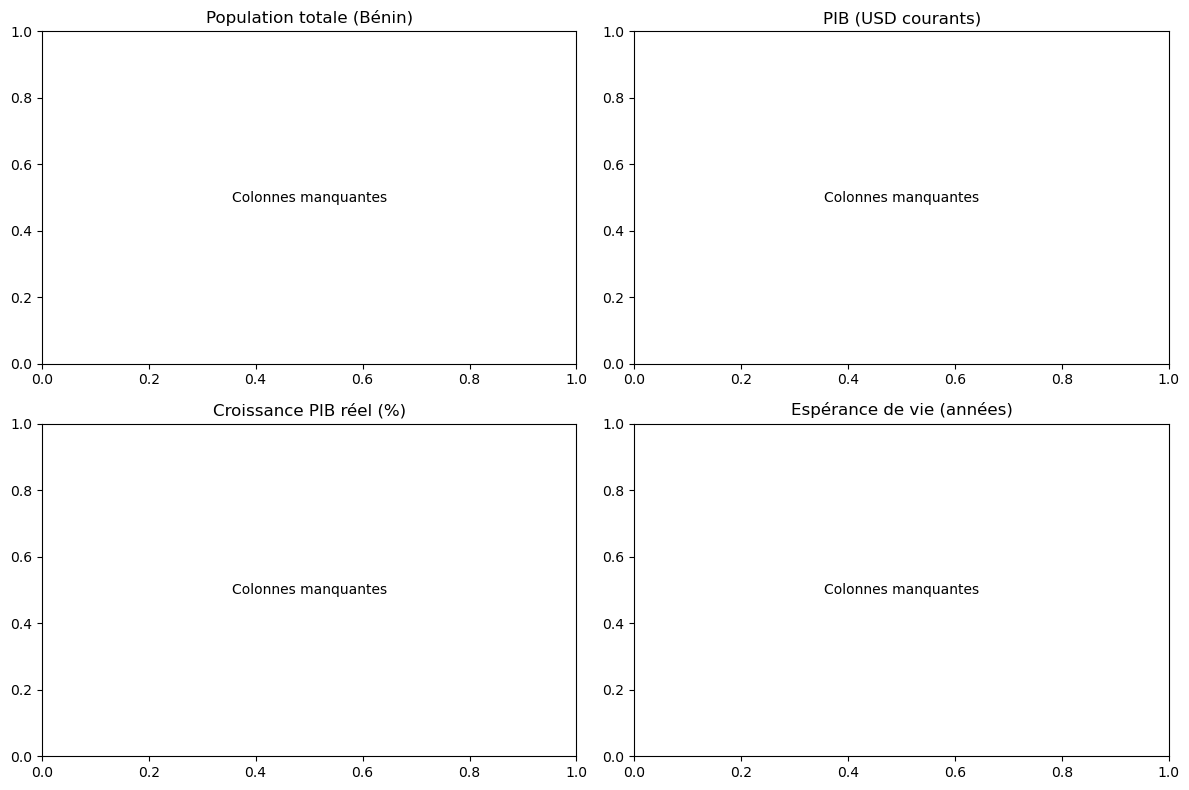

In [18]:
#12
#Visualisation intermédiaire avant harmonisation
# Objectif :
#   - Produire une première visualisation des grandes tendances nationales
#     à partir des données nettoyées, avant toute harmonisation.
# Indicateurs visualisés :
#   - Population totale (population_total)
#   - PIB en USD courants (gdp_current_usd)
#   - Croissance du PIB réel en % (gdp_real_growth_pct)
#   - Espérance de vie à la naissance (life_expectancy_years)
# Détails techniques :
#   - Les graphiques sont disposés dans une grille 2x2.
#   - Pour chaque indicateur :
#       → on extrait les colonnes "year" et la variable correspondante.
#       → les doublons et valeurs manquantes sont supprimés.
#       → les années sont triées pour obtenir une évolution chronologique.
#   - Les cas d’absence de données sont signalés directement sur le graphique.
# Intérêt :
#   - Vérifier la cohérence des séries temporelles avant harmonisation.
#   - Détecter visuellement d’éventuelles anomalies (valeurs aberrantes, ruptures).
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

config = [
    ("wb_population_total_benin", "population_total",      axes[0,0], "Population totale (Bénin)", "Personnes"),
    ("wb_gdp_current_usd_benin",  "gdp_current_usd",       axes[0,1], "PIB (USD courants)",        "USD"),
    ("wb_gdp_real_growth_benin",  "gdp_real_growth_pct",   axes[1,0], "Croissance PIB réel (%)",   "%"),
    ("wb_life_expectancy_benin",  "life_expectancy_years", axes[1,1], "Espérance de vie (années)", "Années"),
]

for key, value_col, ax, title, ylabel in config:
    df = cleaned.get(key)
    if df is not None and {"year", value_col}.issubset(df.columns):
        plot_df = (
            df[["year", value_col]]
            .dropna()
            .drop_duplicates(subset=["year"])
            .sort_values("year")
        )
        if not plot_df.empty:
            ax.plot(plot_df["year"], plot_df[value_col])
            ax.set_title(title)
            ax.set_xlabel("Année")
            ax.set_ylabel(ylabel)
        else:
            ax.text(0.5, 0.5, "Aucune donnée exploitable", ha="center", va="center")
            ax.set_title(title)
    else:
        ax.text(0.5, 0.5, "Colonnes manquantes", ha="center", va="center")
        ax.set_title(title)

plt.tight_layout()
plt.show()


Ici, on remarque que les colonnes sont manquantes dans les graphiques. On va donc corriger ça dans le code qui suit.

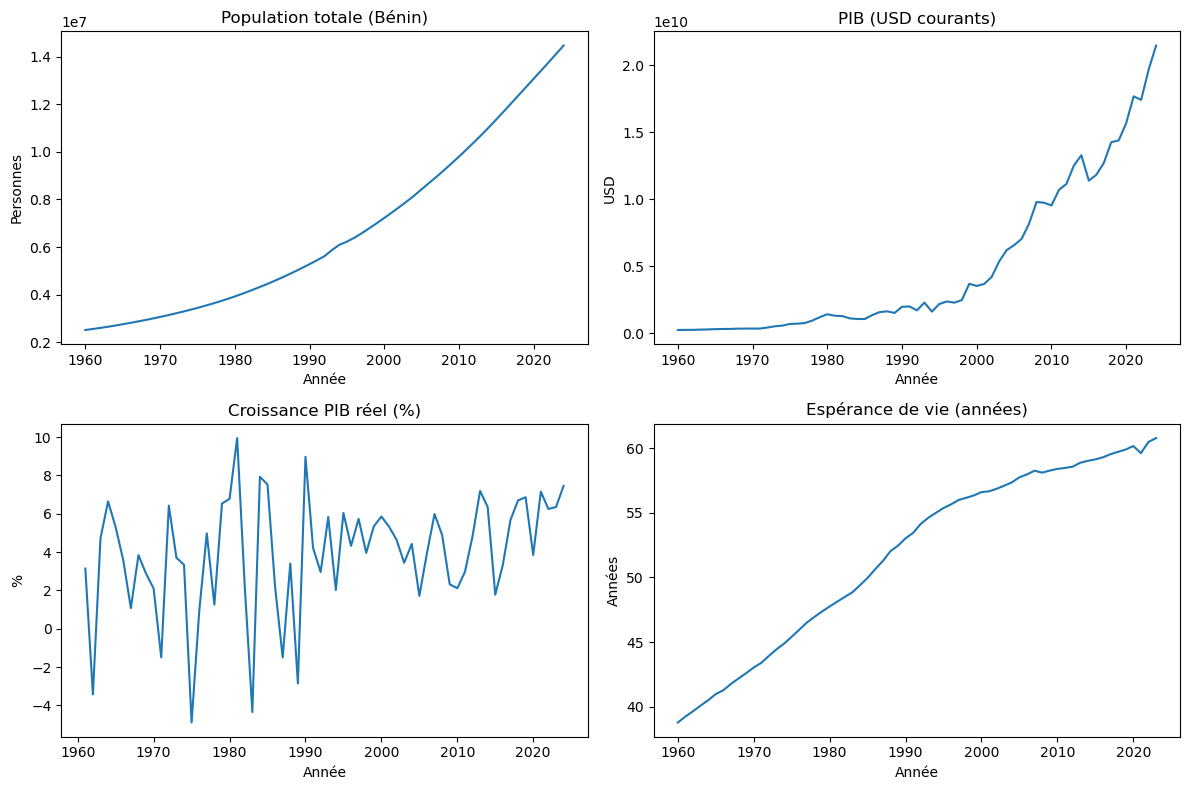

In [19]:
#13
#Standardisation finale des colonnes et visualisation robuste
# Objectif :
#   - Corriger les éventuelles différences de structure entre les datasets nettoyés
#     (ex : colonnes nommées différemment selon la source).
#   - Produire des visualisations plus stables et comparables entre indicateurs.
# Étapes :
#   1. **Standardisation des colonnes**
#       → Renomme les variables clés pour uniformiser les noms (ex. “value” → “population_total”).
#       → Convertit les années en format numérique.
#       → Harmonise les colonnes attendues (population, PIB, croissance, espérance de vie, mortalité maternelle).
#       → Enregistre le résultat dans le dictionnaire `cleaned_std`.
#
#   2. **Fonction utilitaire `get_xy()`**
#       → Simplifie la récupération des colonnes “x” (année) et “y” (valeur à tracer).
#       → Gère les cas où les noms de colonnes varient ou où certaines valeurs sont manquantes.
#
#   3. **Visualisation (4 sous-graphiques)**
#       → Population totale
#       → PIB en USD courants
#       → Croissance du PIB réel (%)
#       → Espérance de vie à la naissance
#
# Intérêt :
#   - Uniformiser la structure des données avant harmonisation nationale.
#   - Éviter les erreurs de traçage liées à des noms de colonnes incohérents comme on a eu précedemment.
#   - Produire des graphes plus propres et exploitables pour la suite du projet.

import pandas as pd
import matplotlib.pyplot as plt

# 1) Crée une version standardisée des DataFrames nettoyés
cleaned_std = {}

for key, df in cleaned.items():
    if df is None or df.empty:
        continue
    d = df.copy()

    # Harmoniser colonne temps
    if "year" not in d.columns and "date" in d.columns:
        d = d.rename(columns={"date": "year"})
    # Convertir year en numérique
    if "year" in d.columns:
        d["year"] = pd.to_numeric(d["year"], errors="coerce")

    # Renommer 'value' -> variable explicite selon la source
    if "value" in d.columns:
        if key == "wb_population_total_benin":
            d = d.rename(columns={"value": "population_total"})
        elif key == "wb_gdp_current_usd_benin":
            d = d.rename(columns={"value": "gdp_current_usd"})
        elif key == "wb_gdp_real_growth_benin":
            d = d.rename(columns={"value": "gdp_real_growth_pct"})
        elif key == "wb_life_expectancy_benin":
            d = d.rename(columns={"value": "life_expectancy_years"})
        elif key == "wb_maternal_mortality_benin":
            d = d.rename(columns={"value": "maternal_mortality_ratio"})

    # Convertir les colonnes numériques attendues
    for col in ["population_total","gdp_current_usd","gdp_real_growth_pct","life_expectancy_years","maternal_mortality_ratio"]:
        if col in d.columns:
            d[col] = pd.to_numeric(d[col], errors="coerce")

    cleaned_std[key] = d

# 2) Fonction utilitaire pour récupérer une série (avec fallback)
def get_xy(d, prefer_colnames, fallback_col="value"):
    if d is None or d.empty:
        return None, None
    # X = year (ou date)
    x = None
    for yc in ["year", "date"]:
        if yc in d.columns:
            x = pd.to_numeric(d[yc], errors="coerce")
            break
    # Y = colonne préférée ou 'value'
    y = None
    for vc in prefer_colnames:
        if vc in d.columns:
            y = pd.to_numeric(d[vc], errors="coerce")
            break
    if y is None and fallback_col in d.columns:
        y = pd.to_numeric(d[fallback_col], errors="coerce")
    return x, y

# 3) Tracer les 4 graphes
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plots = [
    ("wb_population_total_benin",  ["population_total"],      axes[0,0], "Population totale (Bénin)", "Personnes"),
    ("wb_gdp_current_usd_benin",   ["gdp_current_usd"],       axes[0,1], "PIB (USD courants)",        "USD"),
    ("wb_gdp_real_growth_benin",   ["gdp_real_growth_pct"],   axes[1,0], "Croissance PIB réel (%)",   "%"),
    ("wb_life_expectancy_benin",   ["life_expectancy_years"], axes[1,1], "Espérance de vie (années)", "Années"),
]

for key, ycols, ax, title, ylabel in plots:
    d = cleaned_std.get(key, cleaned.get(key))
    x, y = get_xy(d, ycols)
    if d is not None and x is not None and y is not None:
        plot_df = pd.DataFrame({"x": x, "y": y}).dropna().drop_duplicates("x").sort_values("x")
        if not plot_df.empty:
            ax.plot(plot_df["x"], plot_df["y"])
            ax.set_title(title)
            ax.set_xlabel("Année")
            ax.set_ylabel(ylabel)
        else:
            ax.text(0.5, 0.5, "Aucune donnée exploitable", ha="center", va="center")
            ax.set_title(title)
    else:
        ax.text(0.5, 0.5, "Colonnes manquantes", ha="center", va="center")
        ax.set_title(title)

plt.tight_layout()
plt.show()


# Visualisation multi-indicateurs (4 graphiques)
En haut à gauche : évolution de la population totale du Bénin
En haut à droite : évolution du PIB (USD courants)
En bas à gauche : évolution du taux de croissance du PIB réel (%)
En bas à droite : évolution de l'espérance de vie à la naissance (années)
Chaque graphique utilise les données nettoyées de "cleaned" et affiche les tendances par année.
Maintenant, passons à l'harmonisation des données.

In [20]:
#14
# Pré-standardisation avant harmonisation :
# Objectif :
#   - S’assurer que tous les jeux de données partagent les mêmes clés
#     avant de passer à la phase d’harmonisation.
#   - Garantir la présence des colonnes indispensables :
#       → "year"  : pour les analyses temporelles
#       → "iso3"  : pour les jointures et les comparaisons géographiques
# Étapes de traitement :
#   1. Conversion de la colonne "date" en "year" (format numérique entier).
#   2. Normalisation du code pays :
#         - Renomme "countryiso2code" en "iso2" si nécessaire.
#         - Convertit "iso2" (BJ) en "iso3" (BEN).
#   3. Ajout d’un fallback :
#         - Si aucun code ISO n’est présent, on affecte directement "BEN"
#           car toutes les données concernent le Bénin.
#   4. Sauvegarde du résultat dans le dictionnaire `cleaned_std`.
# Vérification :
#   - Pour chaque dataset, le script affiche la présence des colonnes
#     'year' et 'iso3' afin de confirmer la cohérence des clés.
# Intérêt :
#   - Préparer les données à la fusion multi-sources sans erreurs de clé.
#   - Faciliter la future harmonisation et consolidation.

import pandas as pd

cleaned_std = {}
for name, df in cleaned.items():
    d = df.copy()

    # 1) Année : date -> year
    if "year" not in d.columns and "date" in d.columns:
        d = d.rename(columns={"date": "year"})
    if "year" in d.columns:
        d["year"] = pd.to_numeric(d["year"], errors="coerce").astype("Int64")

    # 2) Code pays : countryiso2code -> iso2
    if "iso2" not in d.columns and "countryiso2code" in d.columns:
        d = d.rename(columns={"countryiso2code": "iso2"})

    # 3) iso3 à partir de iso2 (BJ -> BEN) si possible
    if "iso3" not in d.columns and "iso2" in d.columns:
        d["iso3"] = d["iso2"].astype("string").str.upper().map({"BJ": "BEN"})

    # 4) Fallback : si toujours pas d'iso3 (toutes nos sources sont BEN)
    if "iso3" not in d.columns:
        d["iso3"] = "BEN"

    cleaned_std[name] = d

# Petit contrôle des clés
for name, d in cleaned_std.items():
    print(f"{name}: year -> {'year' in d.columns}, iso3 -> {'iso3' in d.columns}")


wb_life_expectancy_benin: year -> True, iso3 -> True
wb_population_total_benin: year -> True, iso3 -> True
wb_maternal_mortality_benin: year -> True, iso3 -> True
wb_gdp_current_usd_benin: year -> True, iso3 -> True
wb_gdp_real_growth_benin: year -> True, iso3 -> True


In [21]:
# 15
#Harmonisation des jeux de données
# Objectif :
#   - Finaliser la préparation des données avant la consolidation.
#   - Appliquer des fonctions d’harmonisation communes pour uniformiser
#     les formats, les clés et les structures des différents jeux de données.
# Étapes :
#   1. Application de `harmonize_geo(df)` :
#        → Standardise les informations géographiques (codes pays, régions, etc.).
#        → Utile si de futures sources incluent plusieurs pays ou niveaux spatiaux.
#   2. Application de `harmonize_year(df)` :
#        → Convertit et valide le type de la colonne "year" (entier, valeurs cohérentes).
#        → Supprime ou corrige les années invalides si nécessaire.
#   3. Sauvegarde du résultat dans le dictionnaire `harmo`,
#      qui contient désormais les versions harmonisées de chaque dataset.
# Vérification :
#   - Affiche pour chaque jeu de données la présence des clés essentielles :
#       → "iso3" (code pays normalisé)
#       → "year" (colonne temporelle)
# Intérêt :
#   - Garantir la compatibilité des tables avant la consolidation finale.
#   - Réduire les risques d’erreur lors des jointures multi-sources.

harmo = {}
for name, df in cleaned_std.items():
    df = harmonize_geo(df)   # utile si d'autres cas/mappings arrivent
    df = harmonize_year(df)  # garantit le type de year
    harmo[name] = df

# Contrôle post-harmonisation
for name, df in harmo.items():
    print(f"{name}: keys -> {{'iso3': {'iso3' in df.columns}, 'year': {'year' in df.columns}}}")


wb_life_expectancy_benin: keys -> {'iso3': True, 'year': True}
wb_population_total_benin: keys -> {'iso3': True, 'year': True}
wb_maternal_mortality_benin: keys -> {'iso3': True, 'year': True}
wb_gdp_current_usd_benin: keys -> {'iso3': True, 'year': True}
wb_gdp_real_growth_benin: keys -> {'iso3': True, 'year': True}


In [22]:
#16
#Vérification qualité après harmonisation
# Objectif :
#   - Contrôler l’intégrité et la cohérence des jeux de données
#     après la phase d’harmonisation.
# Étapes de contrôle :
#   - Pour chaque DataFrame dans `harmo` :
#       1. Vérifie les codes pays (`iso3`) présents.
#       2. Affiche la plage temporelle couverte (année minimale → maximale).
#       3. Calcule le pourcentage de valeurs manquantes par colonne.
#       4. Détecte les doublons éventuels sur la clé ("iso3", "year").
#       5. Affiche les 5 premières lignes pour validation visuelle.
# Intérêt :
#   - Confirmer que les transformations précédentes (standardisation et harmonisation)
#     n’ont pas supprimé d’informations ni créé d’anomalies.
#   - Détecter les éventuelles incohérences avant la consolidation finale :
#       → valeurs manquantes,
#       → doublons,
#       → années hors période cible.

for name, df in harmo.items():
    print(f"\n--- {name} ---")
    if "iso3" in df.columns:
        print("ISO3 uniques:", df['iso3'].unique())
    if "year" in df.columns:
        print("Plage années:", df['year'].min(), "→", df['year'].max())
    print("Valeurs manquantes (%) :")
    display((df.isna().mean()*100).round(1))
    # Cherche des doublons éventuels sur (iso3, year)
    if {"iso3","year"}.issubset(df.columns):
        dups = df.duplicated(subset=["iso3","year"]).sum()
        print("Doublons iso3+year :", dups)
    display(df.head(5))



--- wb_life_expectancy_benin ---
ISO3 uniques: ['BEN']
Plage années: 1960 → 2024
Valeurs manquantes (%) :


countryiso3code    0.0
year               0.0
value              1.5
unit               0.0
obs_status         0.0
decimal            0.0
indicator.id       0.0
indicator.value    0.0
country.id         0.0
country.value      0.0
iso3               0.0
dtype: float64

Doublons iso3+year : 0


,countryiso3code,year,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value,iso3
0,BEN,2024,NaN,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,BEN
1,BEN,2023,60.774,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,BEN
2,BEN,2022,60.475,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,BEN
3,BEN,2021,59.610,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,BEN
4,BEN,2020,60.154,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,BEN



--- wb_population_total_benin ---
ISO3 uniques: ['BEN']
Plage années: 1960 → 2024
Valeurs manquantes (%) :


countryiso3code    0.0
year               0.0
value              0.0
unit               0.0
obs_status         0.0
decimal            0.0
indicator.id       0.0
indicator.value    0.0
country.id         0.0
country.value      0.0
iso3               0.0
dtype: float64

Doublons iso3+year : 0


,countryiso3code,year,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value,iso3
0,BEN,2024,14462724,,,0,SP.POP.TOTL,"Population, total",BJ,Benin,BEN
1,BEN,2023,14111034,,,0,SP.POP.TOTL,"Population, total",BJ,Benin,BEN
2,BEN,2022,13759501,,,0,SP.POP.TOTL,"Population, total",BJ,Benin,BEN
3,BEN,2021,13413417,,,0,SP.POP.TOTL,"Population, total",BJ,Benin,BEN
4,BEN,2020,13070169,,,0,SP.POP.TOTL,"Population, total",BJ,Benin,BEN



--- wb_maternal_mortality_benin ---
ISO3 uniques: ['BEN']
Plage années: 1960 → 2024
Valeurs manquantes (%) :


countryiso3code     0.0
year                0.0
value              40.0
unit                0.0
obs_status          0.0
decimal             0.0
indicator.id        0.0
indicator.value     0.0
country.id          0.0
country.value       0.0
iso3                0.0
dtype: float64

Doublons iso3+year : 0


,countryiso3code,year,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value,iso3
0,BEN,2024,NaN,,,0,SH.STA.MMRT,"Maternal mortality ratio (modeled estimate, pe...",BJ,Benin,BEN
1,BEN,2023,518.0,,,0,SH.STA.MMRT,"Maternal mortality ratio (modeled estimate, pe...",BJ,Benin,BEN
2,BEN,2022,547.0,,,0,SH.STA.MMRT,"Maternal mortality ratio (modeled estimate, pe...",BJ,Benin,BEN
3,BEN,2021,584.0,,,0,SH.STA.MMRT,"Maternal mortality ratio (modeled estimate, pe...",BJ,Benin,BEN
4,BEN,2020,578.0,,,0,SH.STA.MMRT,"Maternal mortality ratio (modeled estimate, pe...",BJ,Benin,BEN



--- wb_gdp_current_usd_benin ---
ISO3 uniques: ['BEN']
Plage années: 1960 → 2024
Valeurs manquantes (%) :


countryiso3code    0.0
year               0.0
value              0.0
unit               0.0
obs_status         0.0
decimal            0.0
indicator.id       0.0
indicator.value    0.0
country.id         0.0
country.value      0.0
iso3               0.0
dtype: float64

Doublons iso3+year : 0


,countryiso3code,year,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value,iso3
0,BEN,2024,2.148264e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),BJ,Benin,BEN
1,BEN,2023,1.967329e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),BJ,Benin,BEN
2,BEN,2022,1.742541e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),BJ,Benin,BEN
3,BEN,2021,1.768762e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),BJ,Benin,BEN
4,BEN,2020,1.568674e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),BJ,Benin,BEN



--- wb_gdp_real_growth_benin ---
ISO3 uniques: ['BEN']
Plage années: 1960 → 2024
Valeurs manquantes (%) :


countryiso3code    0.0
year               0.0
value              1.5
unit               0.0
obs_status         0.0
decimal            0.0
indicator.id       0.0
indicator.value    0.0
country.id         0.0
country.value      0.0
iso3               0.0
dtype: float64

Doublons iso3+year : 0


,countryiso3code,year,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value,iso3
0,BEN,2024,7.453116,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin,BEN
1,BEN,2023,6.352777,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin,BEN
2,BEN,2022,6.252947,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin,BEN
3,BEN,2021,7.155452,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin,BEN
4,BEN,2020,3.848792,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin,BEN


In [24]:
#17
#Consolidation robuste + export + contrôles rapides
# Objectif :
#   - Fusionner l’ensemble des tables harmonisées en un dataset unique
#     prêt pour l’analyse et la visualisation.
#   - Rendre la fusion tolérante aux variations de clés disponibles.
# Principe de la fonction `consolidate_robuste()` :
#   - Tente les jointures dans l’ordre de préférence :
#       1) sur ["iso3", "year"]
#       2) à défaut, sur ["year"]
#       3) sinon, sur ["iso3"]
#   - Ignore proprement toute table ne partageant aucune de ces clés
#     avec la table déjà fusionnée (log d’information).
#   - Convertit "year" en entier nullable (Int64) pour éviter les erreurs de type.
# Pipeline :
#   1) Lancer la consolidation → `final_df`.
#   2) Si `final_df` est vide, afficher un message d’alerte.
#   3) Sinon, dédupliquer et trier par clés (iso3, year) si présentes.
#   4) Exporter le résultat en CSV via `export_final(..., "dataset_final.csv")`.
#   5) Réaliser des contrôles rapides :
#        - aperçu des colonnes,
#        - plage d’années,
#        - liste des ISO3,
#        - taux de valeurs manquantes,
#        - affichage des premières lignes.
#   6) Générer quelques mini-visualisations si les colonnes existent :
#        population_total, gdp_current_usd, gdp_real_growth_pct, life_expectancy_years.
# Intérêt :
#   - Garantir une consolidation même si certaines sources n’ont pas toutes les clés.
#   - Produire un fichier final reproductible et immédiatement exploitable.
#   - Offrir un diagnostic visuel et statistique minimal juste après l’export.

import pandas as pd
import matplotlib.pyplot as plt

def consolidate_robuste(datasets: dict) -> pd.DataFrame:
    """
    Fusionne les tables harmonisées en essayant (dans l'ordre) :
    ['iso3','year'] puis ['year'] puis ['iso3'].
    Ignore proprement les tables sans clé commune.
    """
    preferred_keysets = [["iso3","year"], ["year"], ["iso3"]]
    combined = None

    for name, df in datasets.items():
        d = df.copy()
        if "year" in d.columns:
            d["year"] = pd.to_numeric(d["year"], errors="coerce").astype("Int64")

        if combined is None:
            combined = d
            continue

        # Choisir la meilleure clé commune disponible
        common_keys = None
        for keys in preferred_keysets:
            if all(k in d.columns for k in keys) and all(k in combined.columns for k in keys):
                common_keys = keys
                break

        if common_keys:
            combined = combined.merge(d, on=common_keys, how="outer", suffixes=("", f"_{name}"))
        else:
            print(f"[INFO] Table '{name}' ignorée (pas de clé commune parmi iso3/year).")
    return combined if combined is not None else pd.DataFrame()

# Consolidation
final_df = consolidate_robuste(harmo)

if final_df.empty:
    print("Aucune consolidation possible (vérifiez 'year' et 'iso3').")
else:
    # Tri + déduplication par clés (si présentes)
    key_cols = [c for c in ["iso3","year"] if c in final_df.columns]
    if key_cols:
        final_df = final_df.drop_duplicates(subset=key_cols).sort_values(key_cols)

    # Export CSV
    out_path = export_final(final_df, "dataset_final.csv")
    print("Exporté:", out_path, "| shape:", final_df.shape)

   

    # Contrôles rapides
    print("Colonnes :", list(final_df.columns)[:12], "...")
    if "year" in final_df.columns and final_df["year"].notna().any():
        print("Années :", int(final_df["year"].min()), "→", int(final_df["year"].max()))
    if "iso3" in final_df.columns:
        print("ISO3 uniques :", sorted(final_df["iso3"].dropna().unique()))
    display((final_df.isna().mean()*100).round(1).rename("% NA"))
    display(final_df.head(10))

    # Mini-visualisations sur le dataset final (si colonnes présentes)
    def plot_if(col, title, ylabel):
        if {"year", col}.issubset(final_df.columns):
            tmp = (final_df[["year", col]]
                   .dropna().drop_duplicates("year").sort_values("year"))
            if not tmp.empty:
                plt.figure(figsize=(7,4))
                plt.plot(tmp["year"], tmp[col])
                plt.title(title)
                plt.xlabel("Année")
                plt.ylabel(ylabel)
                plt.tight_layout()
                plt.show()

    plot_if("population_total",      "Population totale — dataset final", "Personnes")
    plot_if("gdp_current_usd",       "PIB (USD courants) — dataset final", "USD")
    plot_if("gdp_real_growth_pct",   "Croissance PIB réel (%) — dataset final", "%")
    plot_if("life_expectancy_years", "Espérance de vie — dataset final", "Années")
    


Exporté: /Users/davidakpovi/challenge_tache1_ANIP/data/processed/dataset_final.csv | shape: (65, 47)
Colonnes : ['countryiso3code', 'year', 'value', 'unit', 'obs_status', 'decimal', 'indicator.id', 'indicator.value', 'country.id', 'country.value', 'iso3', 'countryiso3code_wb_population_total_benin'] ...
Années : 1960 → 2024
ISO3 uniques : ['BEN']


countryiso3code                                 0.0
year                                            0.0
value                                           1.5
unit                                            0.0
obs_status                                      0.0
decimal                                         0.0
indicator.id                                    0.0
indicator.value                                 0.0
country.id                                      0.0
country.value                                   0.0
iso3                                            0.0
countryiso3code_wb_population_total_benin       0.0
value_wb_population_total_benin                 0.0
unit_wb_population_total_benin                  0.0
obs_status_wb_population_total_benin            0.0
decimal_wb_population_total_benin               0.0
indicator.id_wb_population_total_benin          0.0
indicator.value_wb_population_total_benin       0.0
country.id_wb_population_total_benin            0.0
country.valu

,countryiso3code,year,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value,...,country.value_wb_gdp_current_usd_benin,countryiso3code_wb_gdp_real_growth_benin,value_wb_gdp_real_growth_benin,unit_wb_gdp_real_growth_benin,obs_status_wb_gdp_real_growth_benin,decimal_wb_gdp_real_growth_benin,indicator.id_wb_gdp_real_growth_benin,indicator.value_wb_gdp_real_growth_benin,country.id_wb_gdp_real_growth_benin,country.value_wb_gdp_real_growth_benin
0,BEN,1960,38.775,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,...,Benin,BEN,NaN,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin
1,BEN,1961,39.233,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,...,Benin,BEN,3.141280,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin
2,BEN,1962,39.643,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,...,Benin,BEN,-3.426410,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin
3,BEN,1963,40.081,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,...,Benin,BEN,4.730028,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin
4,BEN,1964,40.502,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,...,Benin,BEN,6.650759,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin
5,BEN,1965,40.971,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,...,Benin,BEN,5.293863,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin
6,BEN,1966,41.274,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,...,Benin,BEN,3.575863,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin
7,BEN,1967,41.759,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,...,Benin,BEN,1.078399,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin
8,BEN,1968,42.182,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,...,Benin,BEN,3.842336,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin
9,BEN,1969,42.591,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,...,Benin,BEN,2.877498,,,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin


In [25]:
#18
#Reconstruction des indicateurs et génération du "core"
# Objectif :
#   - S'assurer que le DataFrame final (`final_df`) contient bien les colonnes
#     indicateurs standardisées (population_total, gdp_current_usd, etc.).
#   - Reconstituer ces colonnes si elles ont été perdues/renommées pendant les merges.
#   - Produire une version "core" minimale et propre à 7 colonnes clé.
# Principe :
#   1) `value_map` définit le mapping entre la clé de source (harmo) et le nom cible voulu.
#   2) `ensure_indicator_column()` :
#        - si la colonne cible existe déjà → on ne fait rien ;
#        - sinon, on tente de la retrouver parmi les colonnes issues de la consolidation
#          (ex. value_<source>, <col>_<source>, value) ;
#        - à défaut, on la reconstruit directement depuis la table harmonisée correspondante
#          (harmo[source_key]) puis on fusionne sur (iso3, year).
#   3) Application de la fonction à toutes les colonnes cibles pour compléter `final_df`.
#   4) Construction du "core" :
#        - sélection des colonnes essentielles (iso3, year + 5 indicateurs),
#        - tri et déduplication par (iso3, year),
#        - affichage d'un aperçu.
# Intérêt :
#   - Rendre le dataset final autoportant, avec des noms d'indicateurs explicites.
#   - Corriger les effets de suffixes/renommages dus aux merges.
#   - Garantir une version "core" prête pour la visualisation ou le partage.

import pandas as pd

# 1) mapping source -> nom de la colonne cible
value_map = {
    "wb_population_total_benin":  "population_total",
    "wb_gdp_current_usd_benin":   "gdp_current_usd",
    "wb_gdp_real_growth_benin":   "gdp_real_growth_pct",
    "wb_life_expectancy_benin":   "life_expectancy_years",
    "wb_maternal_mortality_benin":"maternal_mortality_ratio",
}

# 2) fonction utilitaire pour trouver/poser une colonne dans final_df
def ensure_indicator_column(final_df, harmo, source_key, target_col):
    """
    Assure que final_df possède la colonne target_col.
    Stratégie :
      a) si target_col est déjà présent → ok
      b) sinon, chercher des candidats issus des merges (value, value_<source>, target_col_<source>)
      c) sinon, extraire depuis harmo[source_key] et fusionner sur (iso3,year)
    Retourne final_df (éventuellement modifié).
    """
    if target_col in final_df.columns:
        return final_df

    # b) chercher des candidats existants dans final_df
    candidates = [
        f"value_{source_key}",                 # colonnes 'value' suffixées par la consolidation
        f"{target_col}_{source_key}",         # si une renomme a existé avant merge
        "value",                               # éventuellement restée sans suffixe
    ]
    for cand in candidates:
        if cand in final_df.columns:
            final_df[target_col] = pd.to_numeric(final_df[cand], errors="coerce")
            return final_df

    # c) reconstruire depuis harmo[source_key]
    src = harmo.get(source_key)
    if src is not None and not src.empty:
        d = src.copy()
        # normaliser year/iso3
        if "year" not in d.columns and "date" in d.columns:
            d = d.rename(columns={"date": "year"})
        if "iso3" not in d.columns and "iso2" in d.columns:
            d["iso3"] = d["iso2"].astype("string").str.upper().map({"BJ":"BEN"})
        if "iso3" not in d.columns:
            d["iso3"] = "BEN"
        # trouver la colonne valeur
        if target_col in d.columns:
            valcol = target_col
        elif "value" in d.columns:
            d = d.rename(columns={"value": target_col})
            valcol = target_col
        else:
            return final_df  # rien à faire

        # garder iso3, year, target_col puis fusionner
        keep = [c for c in ["iso3","year",target_col] if c in d.columns]
        d = d[keep].copy()
        d[target_col] = pd.to_numeric(d[target_col], errors="coerce")

        # clés de fusion disponibles dans final_df
        join_keys = [k for k in ["iso3","year"] if k in final_df.columns]
        if not join_keys:
            # si final_df n'a pas de clés (cas limite), on les ajoute depuis d si possible
            for k in ["iso3","year"]:
                if k in d.columns and k not in final_df.columns:
                    final_df[k] = d[k]
            join_keys = [k for k in ["iso3","year"] if k in final_df.columns and k in d.columns]

        if join_keys:
            final_df = final_df.merge(d, on=join_keys, how="left")
        return final_df

    return final_df

# 3) assurer toutes les colonnes cibles
for src_key, tgt in value_map.items():
    final_df = ensure_indicator_column(final_df, harmo, src_key, tgt)

# 4) générer le core à partir des colonnes désormais présentes
desired_cols = [
    "iso3", "year",
    "population_total",
    "gdp_current_usd",
    "gdp_real_growth_pct",
    "life_expectancy_years",
    "maternal_mortality_ratio",
]
keep_cols = [c for c in desired_cols if c in final_df.columns]
slim_final = final_df[keep_cols].copy()

# tri + déduplication et petit contrôle
key_cols = [c for c in ["iso3","year"] if c in slim_final.columns]
if key_cols:
    slim_final = slim_final.drop_duplicates(subset=key_cols).sort_values(key_cols)

print("Colonnes finales disponibles :", list(final_df.columns))
print("Colonnes core conservées :", keep_cols)
print("Shapes -> final_df:", final_df.shape, "| core:", slim_final.shape)
display(slim_final.head(10))


Colonnes finales disponibles : ['countryiso3code', 'year', 'value', 'unit', 'obs_status', 'decimal', 'indicator.id', 'indicator.value', 'country.id', 'country.value', 'iso3', 'countryiso3code_wb_population_total_benin', 'value_wb_population_total_benin', 'unit_wb_population_total_benin', 'obs_status_wb_population_total_benin', 'decimal_wb_population_total_benin', 'indicator.id_wb_population_total_benin', 'indicator.value_wb_population_total_benin', 'country.id_wb_population_total_benin', 'country.value_wb_population_total_benin', 'countryiso3code_wb_maternal_mortality_benin', 'value_wb_maternal_mortality_benin', 'unit_wb_maternal_mortality_benin', 'obs_status_wb_maternal_mortality_benin', 'decimal_wb_maternal_mortality_benin', 'indicator.id_wb_maternal_mortality_benin', 'indicator.value_wb_maternal_mortality_benin', 'country.id_wb_maternal_mortality_benin', 'country.value_wb_maternal_mortality_benin', 'countryiso3code_wb_gdp_current_usd_benin', 'value_wb_gdp_current_usd_benin', 'unit_w

,iso3,year,population_total,gdp_current_usd,gdp_real_growth_pct,life_expectancy_years,maternal_mortality_ratio
0,BEN,1960,2517286,2.261956e+08,NaN,38.775,NaN
1,BEN,1961,2559223,2.356682e+08,3.141280,39.233,NaN
2,BEN,1962,2604659,2.364350e+08,-3.426410,39.643,NaN
3,BEN,1963,2652908,2.539277e+08,4.730028,40.081,NaN
4,BEN,1964,2704003,2.698190e+08,6.650759,40.502,NaN
5,BEN,1965,2757936,2.899087e+08,5.293863,40.971,NaN
6,BEN,1966,2814317,3.029252e+08,3.575863,41.274,NaN
7,BEN,1967,2872997,3.062220e+08,1.078399,41.759,NaN
8,BEN,1968,2934257,3.263231e+08,3.842336,42.182,NaN
9,BEN,1969,2998222,3.307482e+08,2.877498,42.591,NaN


In [27]:
#19
#Re-génération du dataset final "riche" + version "core"
# Objectif :
#   - Reconstruire un dataset final complet ("final_rich") en séparant :
#       a) les métriques (indicateurs normalisés par année/pays)
#       b) les métadonnées (infos descriptives conservées par source)
#   - Produire simultanément une version "core" à 7 colonnes
#     (iso3, year + 5 indicateurs principaux) pour un usage direct.
# Principe :
#   1) Définir un mapping `value_map` : clé de source → nom d’indicateur cible.
#   2) Normaliser les clés via `ensure_keys()` (iso3, year).
#   3) Séparer les contenus par source en deux blocs :
#        - metrics_parts : [iso3, year, indicateur]
#        - meta_parts    : [iso3, year, colonnes méta] préfixées par "nom_de_source__"
#   4) Fusionner tous les blocs metrics sur (iso3, year) → `final_metrics`.
#   5) Fusionner toutes les métadonnées sur (iso3, year) → `final_meta`.
#   6) Combiner `final_metrics` et `final_meta` → `final_rich`.
#   7) Trier/dédupliquer par (iso3, year), puis exporter en CSV.
#   8) Générer `slim_final` (version "core") en sélectionnant les 7 colonnes cibles,
#      trier/dédupliquer, puis exporter en CSV.
# Sorties :
#   - data/processed/dataset_final.csv        → version riche (métriques + métadonnées)
#   - data/processed/dataset_final_core.csv   → version core (7 colonnes standard)
# Intérêt :
#   - Conserver un jeu complet pour l’audit et la traçabilité (final_rich)
#   - Disposer d’un jeu minimal et propre pour les tableaux de bord et partages (core)

import pandas as pd
from functools import reduce
from pathlib import Path

# 1) mapping "source -> nom de l'indicateur"
value_map = {
    "wb_population_total_benin":  "population_total",
    "wb_gdp_current_usd_benin":   "gdp_current_usd",
    "wb_gdp_real_growth_benin":   "gdp_real_growth_pct",
    "wb_life_expectancy_benin":   "life_expectancy_years",
    "wb_maternal_mortality_benin":"maternal_mortality_ratio",
}

# 2) petites fonctions utilitaires
def ensure_keys(d):
    d = d.copy()
    if "year" in d.columns:
        d["year"] = pd.to_numeric(d["year"], errors="coerce").astype("Int64")
    if "iso3" not in d.columns and "iso2" in d.columns:
        d["iso3"] = d["iso2"].astype("string").str.upper().map({"BJ":"BEN"})
    if "iso3" not in d.columns:
        d["iso3"] = "BEN"
    return d

def select_metadata_cols(df):
    # Conserver quelques colonnes WB souvent utiles si elles existent
    candidates = [
        "country", "country.value", "countryiso2code", "iso2",
        "indicator.id", "indicator.value",
        "unit", "obs_status", "obs_status.value",
        "footnote", "region", "source", "source.value"
    ]
    keep = [c for c in candidates if c in df.columns]
    return keep

# 3) construire séparément :
#   a) un bloc "metrics" (iso3, year + indicateurs renommés)
#   b) un bloc "meta" (iso3, year + métadonnées préfixées par la source)
metrics_parts = []
meta_parts = []

for name, df in harmo.items():
    if df is None or df.empty:
        continue
    d = ensure_keys(df)

    # Déterminer la colonne valeur
    target = value_map.get(name)
    val_col = None
    if target and target in d.columns:
        val_col = target
    elif "value" in d.columns:
        # renommer 'value' si besoin
        if target:
            d = d.rename(columns={"value": target})
            val_col = target
        else:
            val_col = "value"  # fallback

    # a) bloc métriques
    if val_col is not None:
        m = d[["iso3","year", val_col]].copy()
        m[val_col] = pd.to_numeric(m[val_col], errors="coerce")
        metrics_parts.append(m)

    # b) bloc métadonnées (préfixées par la source)
    meta_cols = select_metadata_cols(d)
    if meta_cols:
        meta = d[["iso3","year"] + meta_cols].copy()
        meta = meta.add_prefix(f"{name}__")
        # remettre les clés sans préfixe
        meta = meta.rename(columns={f"{name}__iso3":"iso3", f"{name}__year":"year"})
        meta_parts.append(meta)

# 4) fusionner "metrics" sur (iso3,year)
if metrics_parts:
    final_metrics = reduce(
        lambda L, R: pd.merge(L, R, on=[c for c in ["iso3","year"] if c in L.columns and c in R.columns], how="outer"),
        metrics_parts
    )
else:
    final_metrics = pd.DataFrame(columns=["iso3","year"])

# 5) fusionner "meta" sur (iso3,year)
if meta_parts:
    final_meta = reduce(
        lambda L, R: pd.merge(L, R, on=[c for c in ["iso3","year"] if c in L.columns and c in R.columns], how="outer"),
        meta_parts
    )
else:
    final_meta = pd.DataFrame(columns=["iso3","year"])

# 6) combiner metrics + meta
if not final_metrics.empty and not final_meta.empty:
    final_rich = final_metrics.merge(final_meta, on=["iso3","year"], how="left")
else:
    final_rich = final_metrics if not final_metrics.empty else final_meta

# tri + dédup et export
if {"iso3","year"}.issubset(final_rich.columns):
    final_rich = final_rich.drop_duplicates(subset=["iso3","year"]).sort_values(["iso3","year"])

# chemins d’export
base_dir = Path.cwd().resolve().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
processed_dir = base_dir / "data" / "processed"
processed_dir.mkdir(parents=True, exist_ok=True)

# réécrire le "final complet" avec les métadonnées riches
final_full_path = processed_dir / "dataset_final.csv"
final_rich.to_csv(final_full_path, index=False, encoding="utf-8")
print("Export dataset final (RICHE) :", final_full_path, "| shape:", final_rich.shape)

# conserver le "core" à 7 colonnes tel quel (si déjà créé)
# si besoin, on peut le régénérer proprement à partir de final_rich :
desired_cols = [
    "iso3","year",
    "population_total","gdp_current_usd","gdp_real_growth_pct",
    "life_expectancy_years","maternal_mortality_ratio"
]
keep_cols = [c for c in desired_cols if c in final_rich.columns]
slim_final = final_rich[keep_cols].drop_duplicates(subset=["iso3","year"]).sort_values(["iso3","year"])

final_core_path = processed_dir / "dataset_final_core.csv"
slim_final.to_csv(final_core_path, index=False, encoding="utf-8")
print("Export dataset final (CORE)  :", final_core_path,  "| shape:", slim_final.shape)

# aperçu des colonnes
print("\nColonnes (final riche) - aperçu :")
print(list(final_rich.columns)[:25], "...")
print("\nColonnes (final core)  :")
print(list(slim_final.columns))


Export dataset final (RICHE) : /Users/davidakpovi/challenge_tache1_ANIP/data/processed/dataset_final.csv | shape: (65, 32)
Export dataset final (CORE)  : /Users/davidakpovi/challenge_tache1_ANIP/data/processed/dataset_final_core.csv | shape: (65, 7)

Colonnes (final riche) - aperçu :
['iso3', 'year', 'life_expectancy_years', 'population_total', 'maternal_mortality_ratio', 'gdp_current_usd', 'gdp_real_growth_pct', 'wb_life_expectancy_benin__country.value', 'wb_life_expectancy_benin__indicator.id', 'wb_life_expectancy_benin__indicator.value', 'wb_life_expectancy_benin__unit', 'wb_life_expectancy_benin__obs_status', 'wb_population_total_benin__country.value', 'wb_population_total_benin__indicator.id', 'wb_population_total_benin__indicator.value', 'wb_population_total_benin__unit', 'wb_population_total_benin__obs_status', 'wb_maternal_mortality_benin__country.value', 'wb_maternal_mortality_benin__indicator.id', 'wb_maternal_mortality_benin__indicator.value', 'wb_maternal_mortality_benin__u

In [28]:
#20
#— Export final (CSV + Excel) et création d’un ZIP téléchargeable
# Objectif :
#   - Exporter les deux versions du dataset :
#       1) `final_rich`  → version complète (toutes colonnes/métadonnées)
#       2) `slim_final`  → version "core" (7 colonnes essentielles)
#   - Générer les fichiers aux formats CSV et Excel.
#   - Créer un fichier README.txt décrivant le contenu.
#   - Regrouper le tout dans une archive ZIP et fournir un lien de téléchargement.
# Hypothèses :
#   - Les variables `final_rich` et `slim_final` existent déjà
#     (issues des cellules de consolidation/standardisation).
# Étapes :
#   1) Préparer les chemins d’export dans data/processed/.
#   2) Exporter les datasets en CSV (UTF-8, sans index).
#   3) Exporter les datasets en Excel (tentative avec openpyxl/xlsxwriter, sinon fallback).
#   4) Générer un README.txt décrivant chaque fichier de l’archive.
#   5) Créer l’archive ZIP `datasets_exports.zip` (compression DEFLATED).
#   6) Afficher un lien cliquable pour télécharger le ZIP depuis Jupyter.
# Sorties :
#   - data/processed/dataset_final.csv
#   - data/processed/dataset_final_core.csv
#   - data/processed/dataset_final.xlsx
#   - data/processed/dataset_final_core.xlsx
#   - data/processed/README.txt
#   - data/processed/datasets_exports.zip  +  lien de téléchargement (FileLink)
# Remarques :
#   - Si ni `openpyxl` ni `xlsxwriter` ne sont disponibles, Pandas utilise un moteur par défaut.
#   - Le lien FileLink fonctionne dans Jupyter ; sur d’autres environnements,
#     il peut être nécessaire de récupérer le fichier directement sur le disque.

import pandas as pd
import zipfile, os
from pathlib import Path
from IPython.display import FileLink, display

# Vérifier que final_rich et slim_final existent
try:
    final_rich
    slim_final
except NameError:
    raise RuntimeError("final_rich ou slim_final introuvable. Exécute la cellule de consolidation/exports avant celle-ci.")

# Répertoire d'export
base_dir = Path.cwd().resolve().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
processed_dir = base_dir / "data" / "processed"
processed_dir.mkdir(parents=True, exist_ok=True)

# === 1) Export CSV ===
csv_full = processed_dir / "dataset_final.csv"
csv_core = processed_dir / "dataset_final_core.csv"
final_rich.to_csv(csv_full, index=False, encoding="utf-8")
slim_final.to_csv(csv_core, index=False, encoding="utf-8")
print("CSV exportés :", csv_full.name, ",", csv_core.name)

# === 2) Export Excel ===
xlsx_full = processed_dir / "dataset_final.xlsx"
xlsx_core = processed_dir / "dataset_final_core.xlsx"
engine = None
for eng in ["openpyxl", "xlsxwriter"]:
    try:
        final_rich.to_excel(xlsx_full, index=False, engine=eng)
        slim_final.to_excel(xlsx_core, index=False, engine=eng)
        engine = eng
        break
    except Exception as e:
        pass
if engine is None:
    final_rich.to_excel(xlsx_full, index=False)
    slim_final.to_excel(xlsx_core, index=False)
print("Excel exportés :", xlsx_full.name, ",", xlsx_core.name)

# === 3) Créer un README.txt dans le ZIP pour expliquer les fichiers ===
readme_path = processed_dir / "README.txt"
with open(readme_path, "w", encoding="utf-8") as f:
    f.write(
"""README - Datasets Exportés

1) dataset_final.csv / dataset_final.xlsx
   → version riche (complète) avec toutes les colonnes et métadonnées.

2) dataset_final_core.csv / dataset_final_core.xlsx
   → version épurée, ne garde que les colonnes principales :
      - iso3
      - year
      - population_total
      - gdp_current_usd
      - gdp_real_growth_pct
      - life_expectancy_years
      - maternal_mortality_ratio
"""
    )

# === 4) Créer le ZIP ===
zip_path = processed_dir / "datasets_exports.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for f in [csv_full, csv_core, xlsx_full, xlsx_core, readme_path]:
        if f.exists():
            zf.write(f, arcname=f.name)
            print("Ajouté au ZIP :", f.name)

print("\nZIP généré :", zip_path)

# === 5) Lien de téléchargement ===
rel_zip = os.path.relpath(zip_path, start=os.getcwd())
display(FileLink(rel_zip))


CSV exportés : dataset_final.csv , dataset_final_core.csv
Excel exportés : dataset_final.xlsx , dataset_final_core.xlsx
Ajouté au ZIP : dataset_final.csv
Ajouté au ZIP : dataset_final_core.csv
Ajouté au ZIP : dataset_final.xlsx
Ajouté au ZIP : dataset_final_core.xlsx
Ajouté au ZIP : README.txt

ZIP généré : /Users/davidakpovi/challenge_tache1_ANIP/data/processed/datasets_exports.zip


/Users/davidakpovi/challenge_tache1_ANIP/data/processed/datasets_exports.zip

# NOTE :
Deux versions du dataset final sont générées :
1) dataset_final.csv: elle contient la version complète issue de la consolidation
et toutes les colonnes importées (y compris colonnes intermédiaires, suffixées, etc.)

2) dataset_final_core.csv : elle contient la version épurée et harmonisée et ne garde que les variables principales et prêtes pour l'analyse :
 - iso3
 - year
 - population_total
 - gdp_current_usd
 - gdp_real_growth_pct
 - life_expectancy_years
 - maternal_mortality_ratio

En pratique, pour les analyses, on utilisera de préférence "dataset_final_core.csv".


In [31]:
# 21
# GLOSSAIRE DES VARIABLES – DATASET FINAL
# Objectif :
#   - Créer un dictionnaire des variables présentes dans le dataset final.
#   - Documenter pour chaque variable : nom, définition, unité, source, période et niveau géographique.
#   - Exporter le glossaire au format Excel pour une utilisation dans le rapport ou le dépôt Git/Drive.


import pandas as pd
from pathlib import Path

# 1) Définir le chemin de base du projet
BASE = Path("/Users/davidakpovi/challenge_tache1_ANIP")
PROC = BASE / "data" / "processed"

# 2) Créer le glossaire sous forme de tableau
glossaire = pd.DataFrame([
    {
        "Nom": "iso3",
        "Définition": "Code pays à trois lettres selon la norme ISO 3166-1 alpha-3 (ex : BEN pour le Bénin).",
        "Unité": "-",
        "Source": "Harmonisation interne",
        "Période": "1960–2024",
        "Géographie": "National (Bénin)"
    },
    {
        "Nom": "year",
        "Définition": "Année calendaire correspondant à l'observation ou à l'estimation.",
        "Unité": "-",
        "Source": "Toutes sources agrégées",
        "Période": "1960–2024",
        "Géographie": "National"
    },
    {
        "Nom": "population_total",
        "Définition": "Population totale estimée pour le Bénin.",
        "Unité": "Personnes",
        "Source": "World Bank – World Development Indicators (WDI)",
        "Période": "1960–2024",
        "Géographie": "National"
    },
    {
        "Nom": "gdp_current_usd",
        "Définition": "Produit Intérieur Brut en valeur courante, exprimé en dollars américains.",
        "Unité": "USD",
        "Source": "World Bank – World Development Indicators (WDI)",
        "Période": "1960–2024",
        "Géographie": "National"
    },
    {
        "Nom": "gdp_real_growth_pct",
        "Définition": "Taux de croissance annuel du PIB réel (corrigé de l'inflation).",
        "Unité": "%",
        "Source": "World Bank – World Development Indicators (WDI)",
        "Période": "1960–2024",
        "Géographie": "National"
    },
    {
        "Nom": "life_expectancy_years",
        "Définition": "Espérance de vie à la naissance, exprimée en années.",
        "Unité": "Années",
        "Source": "World Bank – World Development Indicators (WDI)",
        "Période": "1960–2024",
        "Géographie": "National"
    },
    {
        "Nom": "maternal_mortality_ratio",
        "Définition": "Nombre de décès maternels pour 100 000 naissances vivantes.",
        "Unité": "Pour 100 000 naissances vivantes",
        "Source": "World Bank – World Development Indicators (WDI)",
        "Période": "1960–2024",
        "Géographie": "National"
    },
])

# 3) Export du glossaire au format Excel dans le dossier "data/processed"
gloss_path = PROC / "glossaire_variables.xlsx"
glossaire.to_excel(gloss_path, index=False)

print("Glossaire exporté avec succès :", gloss_path)


Glossaire exporté avec succès : /Users/davidakpovi/challenge_tache1_ANIP/data/processed/glossaire_variables.xlsx


## Contrôles Qualité (QC)

In [29]:
#22
#— Contrôle de qualité sur le dataset final
# Objectif :
#   - Vérifier que `final_df` (issu de la consolidation) est cohérent et exploitable.
# Contrôles effectués :
#   1) Structure : dimensions (shape) et liste des colonnes disponibles.
#   2) Données manquantes : pourcentage de NA par colonne (diagnostic rapide).
#   3) Clés de jointure :
#        - ISO3 : présence de "BEN" et valeurs uniques observées.
#        - YEAR : plage temporelle couverte (min → max) et alerte si hors 1960–2025.
#   4) Aperçu : affichage des 5 premières lignes pour validation visuelle.
# Remarques :
#   - Cette cellule suppose que `final_df` a été créé (consolidation exécutée).
#   - La plage 1960–2025 est un garde-fou : adapte-la si ton périmètre évolue.
#   - Si des alertes apparaissent (codes ISO manquants, années hors plage, NA élevés),
#     revenir aux étapes d’harmonisation/nettoyage pour corriger.

import pandas as pd

if 'final_df' not in locals():
    raise RuntimeError("Exécutez d'abord la consolidation pour créer final_df.")

print("=== Quality Report ===")

# 1) Taille et colonnes
print("Shape :", final_df.shape)
print("Colonnes :", list(final_df.columns))

# 2) Taux de valeurs manquantes
na_report = (final_df.isna().mean()*100).round(1).rename("% NA")
display(na_report)

# 3) Vérification des clés iso3 et year
if "iso3" in final_df.columns:
    iso3_unique = final_df["iso3"].dropna().unique()
    print("ISO3 uniques :", iso3_unique)
    if "BEN" not in iso3_unique:
        print("[ALERTE] Le code BEN n’est pas présent dans iso3.")

if "year" in final_df.columns:
    year_min, year_max = final_df["year"].min(), final_df["year"].max()
    print("Années couvertes :", int(year_min), "→", int(year_max))
    if year_min < 1960 or year_max > 2025:
        print(f"[ALERTE] Période hors plage attendue (1960–2025).")

# 4) Aperçu des 5 premières lignes
display(final_df.head())


=== Quality Report ===
Shape : (65, 52)
Colonnes : ['countryiso3code', 'year', 'value', 'unit', 'obs_status', 'decimal', 'indicator.id', 'indicator.value', 'country.id', 'country.value', 'iso3', 'countryiso3code_wb_population_total_benin', 'value_wb_population_total_benin', 'unit_wb_population_total_benin', 'obs_status_wb_population_total_benin', 'decimal_wb_population_total_benin', 'indicator.id_wb_population_total_benin', 'indicator.value_wb_population_total_benin', 'country.id_wb_population_total_benin', 'country.value_wb_population_total_benin', 'countryiso3code_wb_maternal_mortality_benin', 'value_wb_maternal_mortality_benin', 'unit_wb_maternal_mortality_benin', 'obs_status_wb_maternal_mortality_benin', 'decimal_wb_maternal_mortality_benin', 'indicator.id_wb_maternal_mortality_benin', 'indicator.value_wb_maternal_mortality_benin', 'country.id_wb_maternal_mortality_benin', 'country.value_wb_maternal_mortality_benin', 'countryiso3code_wb_gdp_current_usd_benin', 'value_wb_gdp_current

countryiso3code                                 0.0
year                                            0.0
value                                           1.5
unit                                            0.0
obs_status                                      0.0
decimal                                         0.0
indicator.id                                    0.0
indicator.value                                 0.0
country.id                                      0.0
country.value                                   0.0
iso3                                            0.0
countryiso3code_wb_population_total_benin       0.0
value_wb_population_total_benin                 0.0
unit_wb_population_total_benin                  0.0
obs_status_wb_population_total_benin            0.0
decimal_wb_population_total_benin               0.0
indicator.id_wb_population_total_benin          0.0
indicator.value_wb_population_total_benin       0.0
country.id_wb_population_total_benin            0.0
country.valu

ISO3 uniques : ['BEN']
Années couvertes : 1960 → 2024


,countryiso3code,year,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value,...,decimal_wb_gdp_real_growth_benin,indicator.id_wb_gdp_real_growth_benin,indicator.value_wb_gdp_real_growth_benin,country.id_wb_gdp_real_growth_benin,country.value_wb_gdp_real_growth_benin,population_total,gdp_current_usd,gdp_real_growth_pct,life_expectancy_years,maternal_mortality_ratio
0,BEN,1960,38.775,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,...,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin,2517286,2.261956e+08,NaN,38.775,NaN
1,BEN,1961,39.233,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,...,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin,2559223,2.356682e+08,3.141280,39.233,NaN
2,BEN,1962,39.643,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,...,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin,2604659,2.364350e+08,-3.426410,39.643,NaN
3,BEN,1963,40.081,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,...,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin,2652908,2.539277e+08,4.730028,40.081,NaN
4,BEN,1964,40.502,,,0,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)",BJ,Benin,...,1,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),BJ,Benin,2704003,2.698190e+08,6.650759,40.502,NaN


> **NOTE :**  
> J'ai placé un contrôle de qualité après l'export final pour valider les fichiers livrés.  
> Cela permet de vérifier que le dataset exporté (**final** et **core**) est conforme :  
> - structure attendue (colonnes, dimensions)  
> - cohérence des clés *iso3* et *year*  
> - taux de valeurs manquantes  
> - plage temporelle correcte (1960–2024 pour le Bénin)  
>
> Ce rapport sert de preuve de qualité dans le rendu final.
